<a href="https://colab.research.google.com/github/neuromatch/NeuroAI_Course/blob/main/tutorials/W1D5_Microcircuits/student/W1D5_Tutorial3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/neuromatch/NeuroAI_Course/main/tutorials/W1D5_Microcircuits/student/W1D5_Tutorial3.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

# Tutorial 3: Attention

**Week 1, Day 5: Microcircuits**

**By Neuromatch Academy**

__Content creators:__ Saaketh Medepalli, Aditya Singh, Saeed Salehi, Xaq Pitkow

__Content reviewers:__ Yizhou Chen, RyeongKyung Yoon, Ruiyi Zhang, Lily Chamakura, Hlib Solodzhuk

__Production editors:__ Konstantine Tsafatinos, Ella Batty, Spiros Chavlis, Samuele Bolotta, Hlib Solodzhuk


---
# Tutorial Objectives

By the end of this tutorial, we aim to:


1. Learn how the brain and AI systems implemention attention

2. Understand how multiplicative interactions allow flexible gating of information

3. Demonstrate the inductive bias of the self-attention mechanism towards learning functions of sparse subsets of variables

A key microarchitectural operation in brains and machines is **attention**. The essence of this operation is multiplication. Unlike the vanilla neural network operation -- a nonlinear function of a weighted sum of inputs $f(\sum_j w_{j}x_j)$ -- the attention operation allows responses to *multiply* inputs. This enable computations like modulating weights by other inputs.

&nbsp;

In brains, the theory of the Spotlight of Attention (Posner et al 1980) posited that gain modulation allowed brain computations to select information for later computation. In machines, Rumelhart, Hinton, and McClelland (1986) described Sigma-Pi networks that included both sums ($\Sigma$) and products ($\Pi$) as fundamental operations. The Transformer network (Vaswani et al 2017) used a specific architecture featuring layers of multiplication, sparsification, and normalization. Many machine learning systems since then have fruitfully applied this architecture to language, vision, and many more modalities. In this tutorial we will isolate the central properties and generalization benefits of multiplicative attention shared by all of these applications.

&nbsp;

Exercises include simple attentional modulation of inputs, coding the self-attention mechanism, demonstrating its inductive bias, and interpreting the consequences of attention.

&nbsp;

References:
- Posner MI, Snyder CR, Davidson BJ (1980). Attention and the detection of signals. *Journal of experimental psychology: General*. 109(2):160.

- Rumelhart DE, Hinton G, McClelland JL, PDP Research Group (1986). *Parallel Distributed Processing*. MIT press.

- Vaswani A, Shazeer N, Parmar N, Uszkoreit J, Jones L, Gomez AN, Kaiser Ł, Polosukhin I (2017). [Attention is all you need.](https://papers.nips.cc/paper_files/paper/2017/hash/3f5ee243547dee91fbd053c1c4a845aa-Abstract.html) *Advances in Neural Information Processing Systems*.

- Thomas Viehmann, [toroidal - a lightweight transformer library for PyTorch](https://github.com/MathInf/toroidal)

- Edelman B, Goel S, Kakade S, Zhang C (2022). [Inductive biases and variable creation in self-attention mechanisms](https://proceedings.mlr.press/v162/edelman22a/edelman22a.pdf). *PMLR*.

- Deep Graph Library Tutorials, [Transformer as a Graph Neural Network](https://docs.dgl.ai/en/0.8.x/tutorials/models/4_old_wines/7_transformer.html)

- Lilian Weng, [Attention? Attention!](https://lilianweng.github.io/posts/2018-06-24-attention/)


In [ ]:
# @title Tutorial slides
# @markdown These are the slides for the videos in all tutorials today

from IPython.display import IFrame
link_id = "9n4fj"
print(f"If you want to download the slides: https://osf.io/download/{link_id}/")
IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{link_id}/?direct%26mode=render", width=854, height=480)

---
# Setup


In [ ]:
# @title Install and import feedback gadget

!pip install vibecheck datatops --quiet

from vibecheck import DatatopsContentReviewContainer
def content_review(notebook_section: str):
    return DatatopsContentReviewContainer(
        "",  # No text prompt
        notebook_section,
        {
            "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
            "name": "neuromatch_neuroai",
            "user_key": "wb2cxze8",
        },
    ).render()

feedback_prefix = "W1D5_T3"

In [2]:
# @title Imports
import os
import sys
import math
import torch
import random
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# @title Figure settings
import logging
import matplotlib.cm as cm
import ipywidgets as widgets  # interactive display
from ipywidgets import interactive, FloatSlider, Layout
logging.getLogger('matplotlib.font_manager').disabled = True
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/NMA2020/nma.mplstyle")
fig_w, fig_h = plt.rcParams['figure.figsize']

In [4]:
# @title Plotting functions
def plot_loss_accuracy(t_loss, t_acc, v_loss = None, v_acc = None):
    plt.figure(figsize=(15, 4))
    plt.suptitle("Training and Validation for the Transformer Model")
    plt.subplot(1, 2, 1)
    plt.plot(t_loss, label="Training loss", color="red")
    if v_loss is not None:
        # plt.plot(v_loss, label="Valididation loss", color="blue")
        plt.scatter(len(t_loss)-1, v_loss, label="Validation loss", color="blue", marker="*")
        # plt.text(len(t_loss)-1, v_loss, f"{v_loss:.3f}", va="bottom", ha="right")
    plt.yscale("log")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.xticks([])
    plt.legend(loc="lower right")
    plt.subplot(1, 2, 2)
    plt.plot(t_acc, label="Training accuracy", color="red", linestyle="dotted")
    if v_acc is not None:
        # plt.plot(v_acc, label="Validation accuracy", color="blue", linestyle="--")
        plt.scatter(len(t_acc)-1, v_acc, label="Validation accuracy", color="blue", marker="*")
        # plt.text(len(t_acc)-1, v_acc, f"{v_acc:.3f}", va="bottom", ha="right")
    plt.xticks([])
    plt.ylim(0, 1)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower right")
    plt.show()


def plot_samples(X_plot, y_plot, correct_ids, title=None):
    n_samples, seq_length = X_plot.shape
    fig, axs = plt.subplots(1, 2, figsize=(16, 2.5), sharey=True)
    rects = []
    for ri in correct_ids:
        rects.append(plt.Rectangle((ri-0.5, -0.5), 1, n_samples, edgecolor="red", alpha=1.0, fill=False, linewidth=2))
    axs[0].imshow(X_plot, cmap="binary")
    for rect in rects:
        axs[0].add_patch(rect)
    # axs[0].axis("off")
    axs[0].set_yticks([])
    axs[0].set_xticks([])
    axs[0].set_ylabel("Samples")
    axs[0].set_xlabel("Context")
    if title is not None:
        axs[0].set_title(title)
    axs[1].imshow(y_plot, cmap="binary")
    axs[1].add_patch(plt.Rectangle((-0.5, -0.5), 1, n_samples, edgecolor="black", alpha=1.0, fill=False, linewidth=2))
    axs[1].yaxis.set_label_position("right")
    axs[1].set_ylabel("Labels")
    axs[1].set_yticks([])
    axs[1].set_xticks([])
    plt.subplots_adjust(wspace=-1)
    plt.tight_layout()
    plt.show()


def plot_attention_weights(att_weights, correct_ids, context_length, labels):
    from matplotlib.lines import Line2D
    B = att_weights.size(0)
    aw_flatten = att_weights[:, -1, :-1].view(-1, context_length)
    x_axis = torch.arange(context_length).repeat(B, 1)
    y_axis = labels.view(-1, 1).repeat(1, context_length)
    aw_ravel = aw_flatten.ravel()
    x_ravel = x_axis.ravel()
    y_ravel = y_axis.ravel()

    fig, ax = plt.subplots(figsize=(9, 5))
    colors = ["#1E88E5", "#FFC107"]
    labels_legened = ["True", "False"]
    ax.scatter(x_ravel, aw_ravel, alpha=0.5, c=[colors[int(y)] for y in y_ravel])
    rects = []
    for ri in correct_ids:
        # rects.append(plt.Rectangle((ri-0.5, 1e-6), 1.0, 2.0, edgecolor="blue", alpha=1.0, fill=False, linewidth=2))
        rects.append(plt.Rectangle((ri-0.5, -0.1), 1.0, 0.8, edgecolor="red", alpha=1.0, fill=False, linewidth=2))
    for rect in rects:
        ax.add_patch(rect)
    # plt.yscale("log")
    # plt.ylim(1e-6, 2)
    plt.ylim(-0.1, 0.7)
    plt.title("Attention weights for the whole batch")
    plt.xlabel("Boolean input index t")
    plt.ylabel("Attention weight")
    legend_elements = [Line2D([0], [0], linestyle='None', marker='o', color='#1E88E5', label='True', markerfacecolor='#1E88E5', markersize=7),
                       Line2D([0], [0], linestyle='None', marker='o', color='#FFC107', label='False', markerfacecolor='#FFC107', markersize=7)]
    ax.legend(handles=legend_elements, loc='upper right')
    plt.show()


def plot_attention_weights_stats(att_weights, correct_ids, context_length, labels):
    aw_flatten = att_weights[:, -1, :-1].view(-1, context_length)
    aw_flatten_mean = aw_flatten.mean(dim=0)
    aw_flatten_std = aw_flatten.std(dim=0)
    fig, ax = plt.subplots(figsize=(9, 5))
    ax.errorbar(torch.arange(context_length), aw_flatten_mean, yerr=aw_flatten_std, fmt='o', color='blue')
    rects = []
    for ri in correct_ids:
        rects.append(plt.Rectangle((ri-0.5, -0.1), 1.0, 0.8, edgecolor="red", alpha=1.0, fill=False, linewidth=2))
    for rect in rects:
        ax.add_patch(rect)
    plt.title("Attention weights statistics")
    plt.xlabel("Boolean input index t")
    plt.ylabel("Mean attention weight")
    plt.ylim(-0.1, 0.7)
    plt.show()


def plot_compare(results_sat_d, results_sat_s, results_mlp_d, results_mlp_s,
                 B_t_sat_s, B_t_sat_d, B_t_mlp_s, B_t_mlp_d):
    from  matplotlib.colors import LinearSegmentedColormap
    cmap=LinearSegmentedColormap.from_list('rg',["w", "w", "r", "y", "g"], N=256)

    t_loss_sat_d, t_acc_sat_d, v_loss_sat_d, v_acc_sat_d, model_np_sat_d = results_sat_d
    t_loss_sat_s, t_acc_sat_s, v_loss_sat_s, v_acc_sat_s, model_np_sat_s = results_sat_s
    t_loss_mlp_d, t_acc_mlp_d, v_loss_mlp_d, v_acc_mlp_d, model_np_mlp_d = results_mlp_d
    t_loss_mlp_s, t_acc_mlp_s, v_loss_mlp_s, v_acc_mlp_s, model_np_mlp_s = results_mlp_s

    plt.figure(figsize=(8, 6))
    plt.subplot(2, 2, 1)
    plt.title("sparse", fontsize=16)
    plt.ylabel("Attention", fontsize=16)
    plt.barh(3, 0, color="blue")
    plt.barh(4, 0, color="green")
    plt.text(0.05, 3.5, f"# Parameters: {model_np_sat_s}")
    plt.text(0.05, 3.0, f"# samples: {B_t_sat_s}")
    plt.barh(2, t_acc_sat_s, color=cmap(t_acc_sat_s))
    plt.barh(1, v_acc_sat_s, color=cmap(v_acc_sat_s))
    plt.text(0.05, 2, f"# training acc: {t_acc_sat_s:.0%}")
    plt.text(0.05, 1, f"# validation acc: {v_acc_sat_s:.0%}")
    plt.xticks([])
    plt.yticks([])

    plt.subplot(2, 2, 2)
    plt.title("dense", fontsize=16)
    plt.barh(3, 0, color="blue")
    plt.barh(4, 0, color="green")
    plt.text(0.05, 3.5, f"# Parameters: {model_np_sat_d}")
    plt.text(0.05, 3.0, f"# samples: {B_t_sat_d}")
    plt.barh(2, t_acc_sat_d, color=cmap(t_acc_sat_d))
    plt.barh(1, v_acc_sat_d, color=cmap(v_acc_sat_d))
    plt.text(0.05, 2, f"# training acc: {t_acc_sat_d:.0%}")
    plt.text(0.05, 1, f"# validation acc: {v_acc_sat_d:.0%}")
    plt.xticks([])
    plt.yticks([])

    plt.subplot(2, 2, 3)
    plt.barh(3, 0, color="blue")
    plt.barh(4, 0, color="green")
    plt.text(0.05, 3.5, f"# Parameters: {model_np_mlp_s}")
    plt.text(0.05, 3.0, f"# samples: {B_t_mlp_s}")
    plt.barh(2, t_acc_mlp_s, color=cmap(t_acc_mlp_s))
    plt.barh(1, v_acc_mlp_s, color=cmap(v_acc_mlp_s))
    plt.text(0.05, 2, f"# training acc: {t_acc_mlp_s:.0%}")
    plt.text(0.05, 1, f"# validation acc: {v_acc_mlp_s:.0%}")
    plt.xticks([])
    plt.yticks([])
    plt.ylabel("MLP", fontsize=16)

    plt.subplot(2, 2, 4)
    plt.barh(3, 0, color="blue")
    plt.barh(4, 0, color="green")
    plt.text(0.05, 3.5, f"# Parameters: {model_np_mlp_d}")
    plt.text(0.05, 3.0, f"# samples: {B_t_mlp_d}")
    plt.barh(2, t_acc_mlp_d, color=cmap(t_acc_mlp_d))
    plt.barh(1, v_acc_mlp_d, color=cmap(v_acc_mlp_d))
    plt.text(0.05, 2, f"# training acc: {t_acc_mlp_d:.0%}")
    plt.text(0.05, 1, f"# validation acc: {v_acc_mlp_d:.0%}")
    plt.xticks([])
    plt.yticks([])
    plt.axis("off")
    plt.show()


def plot_weights_and_output(gain_1, gain_2):
    T = 20  # context length
    x = torch.sin(torch.linspace(0, 2*np.pi, T)) + 0.1 * torch.randn(T)
    q_1 = 1.0 - torch.sigmoid(torch.linspace(-3, 7, T))
    q_1 = q_1 / q_1.sum()
    q_2 = torch.sigmoid(torch.linspace(-7, 3, T))
    q_2 = q_2 / q_2.sum()
    w, y = gained_dot_product_attention(x, q_1, q_2, gain_1, gain_2)
    print(f"output y: {y}")
    with plt.xkcd():
        plt.figure(figsize=(8, 6))
        plt.subplot(2, 1, 1)
        plt.plot(q_1, label="$\mathbf{q_1}$", c="m")
        plt.plot(q_2, label="$\mathbf{q_2}$", c="y")
        plt.plot(w, label="$\mathbf{w}$", c="r")
        plt.ylim(-0.1, max(q_1.max(), q_2.max()))
        plt.ylabel("Attention weights")
        plt.xlabel("Context dimension")
        plt.legend()
        plt.subplot(2, 1, 2)
        plt.plot(x, label="$\mathbf{x}$", c="blue")
        plt.plot(5 * x * w, label="$5\mathbf{w}*\mathbf{x}$", c="red")
        plt.ylim(-x.abs().max(), x.abs().max())
        plt.ylabel("Amplitude")
        plt.xlabel("Context")
        plt.legend()
        plt.show()


def plot_attention_graph(model, data_generator, m):
    X_valid, y_valid = data_generator.generate(m, verbose=False)
    logits, scores, attention, output = model(X_valid, elaborate=True)
    with torch.no_grad():
        scores_x_linear = torch.einsum("bij,jk->bik", scores, model.linear.weight.T).detach().cpu()
    w_att_trues_0 = scores_x_linear[(y_valid[:, 0] == 1) & (X_valid[:, -1] == 0)]
    w_att_trues_1 = scores_x_linear[(y_valid[:, 0] == 1) & (X_valid[:, -1] == 1)]
    w_att_trues_0 = w_att_trues_0.mean(dim=0).squeeze(-1)
    w_att_trues_1 = w_att_trues_1.mean(dim=0).squeeze(-1)

    fig, ax = plt.subplots(2, 1, figsize=(10, 8))
    rules = ["Rule = 0", "Rule = 1"]
    for r, x in enumerate((w_att_trues_0, w_att_trues_1)):
        #xc = (x - x.min()) / (x.max() - x.min() + 1e-9)
        xc = (x + x.abs().max()) / (2 * x.abs().max()) # color range spans -max|x| to +max|x|
        xw = x.abs() / x.abs().max()
        xa = (xw - xw.min()) / (xw.max() - xw.min() + 1e-9)
        xabsmax = x.abs().max()
        x, xc, xw, xa = (some_x.numpy() for some_x in (x, xc, xw, xa))
        T = x.shape[0]
        m = (T/2) - 0.5

        ax[r].text(m-1, 1.0, " ", c='k', fontsize=16)
        ax[r].text(m-1, 0.9, f"Graph for {rules[r]}", c='k', fontsize=16)
        for i in range(T):
            c = 'r' if i in data_generator.f_i_1 else 'b' if i in data_generator.f_i_2 else 'm' if i == T-1 else'grey'
            ax[r].plot([i, m], [0, 0.75], c=cm.plasma_r(xc[i]), linewidth=5, alpha=1)
            ax[r].scatter([i], [0], c=c, zorder=100, s=100)
        ax[r].scatter([m], [0.75], c='k', zorder=100, s=200)
        for i, j in zip(data_generator.f_i_1, data_generator.f_i_2):
            ax[r].text(i-0.3, -0.1, "tar_0", c='r', fontsize=12)
            ax[r].text(j-0.3, -0.1, "tar_1", c='b', fontsize=12)
        ax[r].text(m-0.3, 0.8, "Output", c='k', fontsize=12)
        ax[r].text(T-1-0.1, -0.1, "Rule", c='m', fontsize=12)
        cbar = fig.colorbar(cm.ScalarMappable(cmap=cm.plasma_r), ax=ax[r], ticks=[0, 1], label="Attention")
        #cbar.ax.set_yticklabels([f"{x.min():.1f}", f"{x.max():.1f}"])
        cbar.ax.set_yticklabels([f"{-xabsmax:.1f}", f"{xabsmax:.1f}"])
        ax[r].axis('off')
    plt.show()

In [5]:
#@title Data retrieval
class s_Sparse_AND:  # 1-Dimensional AND
    def __init__(self, T: int, s: int):
        self.T = T # context length
        self.s = s # sparsity
        self.p = 0.5**(1.0/3.0)  # probability chosen for balanced data
        self.f_i = None

    def pick_an_f(self):
        self.f_i = sorted(random.sample(range(self.T), self.s))
        self.others = list(i for i in range(self.T) if i not in self.f_i)

    def generate(self, m: int, verbose: bool = False):
        if self.f_i is None:
            self.pick_an_f()
        max_try = 100
        i_try = 0
        while i_try < max_try:
            i_try += 1
            X, y = torch.zeros(m, self.T), torch.zeros(m, 1)
            X[torch.rand(m, self.T) < self.p] = 1
            y[X[:, self.f_i].sum(dim=1) == self.s] = 1
            if y.sum()/m < 0.4 or y.sum()/m > 0.6:
                verbose and print(f"Large imbalance in the training set {y.sum()/m}, retrying...")
                continue
            else:
                verbose and print(f"Data-label balance: {y.sum()/m}")
            bad_batch = False
            for i in self.f_i:
                for o in self.others:
                    if (X[:, i] == X[:, o]).all():
                        verbose and print(f"Found at least another compatible hypothesis {i} and {o}")
                        bad_batch = True
                        break
            if bad_batch:
                continue
            else:
                break
        else:
            verbose and print("Could not find a compatible hypothesis")
        return X.long(), y.float()


class s_Sparse_AND_Query:  # 1-Dimensional AND
    def __init__(self, T, s):
        self.T = T - 1
        self.k = 1  # currently only for k = 1
        self.s = s
        self.p = 0.5**(1.0/2.0)  # probability chosen for balanced data
        self.f_i_1, self.f_i_2, self.f_i = None, None, None

    def pick_an_f(self):
        self.f_i_1 = sorted(random.sample(range(self.T), self.s))
        self.others_1 = list(i for i in range(self.T) if i not in self.f_i_1)
        self.f_i_2 = sorted(random.sample(self.others_1, self.s))
        self.others_2 = list(i for i in self.others_1 if i not in self.f_i_2)
        self.f_i = self.f_i_1 + self.f_i_2

    def __call__(self):
        self.pick_an_f()

    def generate(self, m: int, verbose: bool = False):
        z = torch.randint(0, 2, (m, self.k))
        if self.f_i_1 is None or self.f_i_2 is None:
            self.pick_an_f()
        max_try = 100
        i_try = 0
        while i_try < max_try:
            i_try += 1
            X, y = torch.zeros(m, self.T), torch.zeros(m, 1)
            X[torch.rand(m, self.T) < self.p] = 1
            # remove overlaps
            # X_z_2 = (X[:, self.f_i_1].sum(dim=1) == self.s) & (X[:, self.f_i_2].sum(dim=1) == self.s)
            # randos_i = torch.arange(m)[X_z_2]
            # randos_j = torch.tensor(self.f_i_1 + self.f_i_2)[torch.randint(0, 2*self.s, (m, ))][X_z_2]
            # X[randos_i, randos_j] = 0
            # Rule 0
            X_z_0 = (X[:, self.f_i_1].sum(dim=1) == self.s) & (z[:, 0] == 0)
            y[X_z_0] = 1
            # Rule 1
            X_z_1 = (X[:, self.f_i_2].sum(dim=1) == self.s) & (z[:, 0] == 1)
            y[X_z_1] = 1
            if y.sum()/m < 0.45 or y.sum()/m > 0.55:
                verbose and print(f"Large imbalance in the training set {y.sum()/m}, retrying...")
                continue
            else:
                verbose and print(f"Data-label balance: {y.sum()/m}")
                break
        else:
            verbose and print("Could not find a compatible hypothesis")
        return torch.cat([X, z], dim=1).long(), y.float()


# From notebook
# Load an example image from the imagenet-sample-images repository
def load_image(path):
  """
  Load an image from a given path

  Args:
    path: String
      Path to the image

  Returns:
    img: PIL Image
      Image loaded from the path
  """
  img = Image.open(path)
  return img


In [6]:
# @title Helper functions

class BinaryMLP(torch.nn.Module):
    def __init__(self, in_dims, h_dims, out_dims, dropout=0.1):
        super().__init__()
        self.in_dims = in_dims
        self.h_dims = h_dims
        self.out_dims = out_dims

        self.layers = torch.nn.ModuleList()
        self.layers.append(torch.nn.Linear(in_dims, h_dims[0]))
        torch.nn.init.normal_(self.layers[-1].weight, std=0.02)
        torch.nn.init.zeros_(self.layers[-1].bias)
        self.layers.append(torch.nn.GELU())
        self.layers.append(torch.nn.Dropout(dropout))
        for i in range(len(h_dims) - 1):
            self.layers.append(torch.nn.Linear(h_dims[i], h_dims[i+1]))
            torch.nn.init.normal_(self.layers[-1].weight, std=0.02)
            torch.nn.init.zeros_(self.layers[-1].bias)
            self.layers.append(torch.nn.GELU())
            self.layers.append(torch.nn.Dropout(dropout))
        self.layers.append(torch.nn.Linear(h_dims[-1], out_dims))
        self.layers.append(torch.nn.Sigmoid())

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x



class SelfAttention(torch.nn.Module):
    """Simple Binary Self-Attention
    """
    def __init__(self, T: int, d: int):
        """
        Args:
            T (int): context length
            d (int): embedding size for K, Q but not V
        Note:
            The embedding size for V is the same as the input size i.e. 1
        """
        super().__init__()
        self.T = T  # context length
        self.d = d  # embedding size
        self.scale = self.d ** -0.5  # scaling factor (1 / sqrt(d_k))
        self.v = 2  # vocabulary size (binary input, 0 or 1)
        init_std = 0.001  # standard deviation for weight initialization

        # embedding layers
        self.tokenizer = torch.nn.Embedding(self.v, self.d)  # token embedding
        self.positioner = torch.nn.Parameter(torch.rand(1, self.T, self.d))  # positional embedding

        # self-attention layers
        self.Wq = torch.nn.Linear(self.d, self.d, bias=False)  # query layer
        self.Wk = torch.nn.Linear(self.d, self.d, bias=False)  # key layer
        self.Wv = torch.nn.Linear(self.d, 1, bias=False)  # value layer

        # projection layer
        self.linear = torch.nn.Linear(self.T, 1, bias=False)  # projection layer
        torch.nn.init.normal_(self.linear.weight, std=init_std)
        # torch.nn.init.zeros_(self.linear.bias)

        # initialize weights and biases (per description in the paper)
        torch.nn.init.normal_(self.tokenizer.weight, std=init_std)
        torch.nn.init.normal_(self.positioner, std=init_std)
        torch.nn.init.normal_(self.Wq.weight, std=init_std)
        # torch.nn.init.zeros_(self.Wq.bias)
        torch.nn.init.normal_(self.Wk.weight, std=init_std)
        # torch.nn.init.zeros_(self.Wk.bias)
        torch.nn.init.normal_(self.Wv.weight, std=init_std)
        # torch.nn.init.zeros_(self.Wv.bias)

    def forward(self, x: torch.Tensor, elaborate: bool = False):
        """Forward pass
        Args:
            x (torch.Tensor): input tensor of shape (B, T, d)
        """
        # Embedding
        x = self.tokenizer(x)
        x = x + self.positioner

        # (Scaled Dot-Product Attention)
        Q = self.Wq(x)
        K = self.Wk(x)
        V = self.Wv(x)
        logits = torch.einsum("btc,bsc->bts", Q, K)  # query key product
        logits *= self.scale  # normalize against staturation
        scores = torch.softmax(logits, dim=-1)  # attention scores
        attention = torch.einsum("bts,bsc->btc", scores, V)  # scaled dot-product attention
        attention = attention.squeeze(-1)  # remove last dimension
        output = self.linear(attention) # linear layer
        output = torch.sigmoid(output)  # sigmoid activation
        return (logits, scores, attention, output) if elaborate else output


class PositionalEncoding(torch.nn.Module):
    def __init__(self, T: int, d_model: int):
        super().__init__()
        Te = T + T%2
        de = d_model + d_model%2
        position = torch.arange(Te).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, de, 2) * (-math.log(10000.0) / de))
        pe = torch.zeros(Te, de)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe[:T, :d_model]
        self.register_buffer('pe', pe)

    def forward(self):
        return self.pe


class SDPA_Solution(torch.nn.Module):
    def __init__(self, T: int, dm: int, dk: int):
        """
        Scaled Dot Product Attention
        Args:
            T (int): context length
            dm (int): model dimension
            dk (int): key dimension
        Note:
            we assume dm == dv
        """
        super().__init__()
        self.T = T  # context length
        self.dm = dm  # model dimension
        self.dk = dk  # key dimension
        self.scale = 1.0 / math.sqrt(dk)

        # positional Encoding
        self.position = PositionalEncoding(T, dm)

        # self-attention layers
        self.Wq = torch.nn.Linear(dm, dk, bias=False)  # query layer
        self.Wk = torch.nn.Linear(dm, dk, bias=False)  # key layer
        self.Wv = torch.nn.Linear(dm, dm, bias=False)  # value layer

    def forward(self, x: torch.Tensor):
        """
        Args:
            x (torch.Tensor): input tensor of shape (T, d)
        """
        # Positional Encoding
        x = x + self.position()

        # (Scaled Dot-Product Attention)
        Q = self.Wq(x)  # Query
        K = self.Wk(x)  # Key
        V = self.Wv(x)  # Value
        QK = Q @ K.T  # Query Key product
        S = QK * self.scale  # Scores (scaled against staturation)
        S_softmax = torch.softmax(S, dim=-1)  # softmax attention scores (row dimensions)
        A = S_softmax @ V  # scaled dot-product attention
        return A


def test_sdpa(your_implementation):
    # self-attention layers
    context_len = 7
    model_dim = 5
    key_dim = 3
    toy_x = torch.rand(context_len, model_dim)
    your_model = your_implementation(context_len, model_dim, key_dim)
    our_model = SDPA_Solution(context_len, model_dim, key_dim)
    your_model.Wq = our_model.Wq
    your_model.Wk = our_model.Wk
    your_model.Wv = our_model.Wv
    your_results = your_model(toy_x.clone())
    our_results = our_model(toy_x.clone())
    if (your_results == our_results).all():
        print("Very well Done!")
    else:
        print("The two implementations should produce the same result!")


def bin_acc(y_hat, y):
    """
    Compute the binary accuracy
    """
    y_ = y_hat.round()
    TP_TN = (y_ == y).float().sum().item()
    FP_FN = (y_ != y).float().sum().item()
    assert TP_TN + FP_FN == y.numel(), f"{TP_TN + FP_FN} != {y.numel()}"
    return TP_TN / y.numel()


def get_n_parameters(model: torch.nn.Module):
    """
    Get the number of learnable parameters in a model
    """
    i = 0
    for par in model.parameters():
        i += par.numel()
    return i


def save_model(model):
    torch.save(model.state_dict(), 'model_states.pt')


def load_model(model):
    model_states = torch.load('model_states.pt')
    model.load_state_dict(model_states)


class Trainer:
    def __init__(self, model, optimizer, criterion):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion

    def do_eval(self, X_v, y_v, device="cpu"):
        self.model.to(device)
        self.model.eval()
        X_v, y_v = X_v.to(device), y_v.to(device)
        with torch.no_grad():
            y_hat = self.model(X_v)
            loss = self.criterion(y_hat.squeeze(), y_v.squeeze())
            acc = bin_acc(y_hat, y_v)
        self.model.to("cpu")
        return loss.item(), acc

    def do_train(self, n_epochs, X_t, y_t, device="cpu"):
        train_loss, train_acc = [], []
        self.model.to(device)
        self.model.train()
        X_t, y_t = X_t.to(device), y_t.to(device)
        for i in range(n_epochs):
            self.optimizer.zero_grad(set_to_none=True)
            y_hat = self.model(X_t)
            loss_t = self.criterion(y_hat.squeeze(), y_t.squeeze())
            loss_t.backward()
            self.optimizer.step()
            self.optimizer.zero_grad(set_to_none=True)
            if (i + 1) % 10 == 0 or i == 0:
                train_loss.append(loss_t.item())
                train_acc.append(bin_acc(y_hat, y_t))
        self.model.eval()
        self.model.to("cpu")
        return train_loss, train_acc


def make_train(model, data_gen, B_t, B_v, n_epochs, device="cpu", kind="MLP", verbose=False, etta=1e-2):
    X_train, y_train = data_gen.generate(B_t, verbose=False)
    X_valid, y_valid = data_gen.generate(B_v, verbose=False)
    optimizer = torch.optim.Adam(model.parameters(), lr=etta)
    criterion = torch.nn.BCELoss()
    train_eval = Trainer(model, optimizer, criterion)
    model_np = get_n_parameters(model)  # number of learnable parameters
    verbose and print(f"Number of model's learnable parameters: {model_np}")
    if kind == "MLP":
        t_loss, t_acc = train_eval.do_train(n_epochs, X_train.float(), y_train, device=device)
        v_loss, v_acc = train_eval.do_eval(X_valid.float(), y_valid, device=device)
    else:
        t_loss, t_acc = train_eval.do_train(n_epochs, X_train, y_train, device=device)
        v_loss, v_acc = train_eval.do_eval(X_valid, y_valid, device=device)
    verbose and print(f"Training loss: {t_loss[-1]:.3f}, accuracy: {t_acc[-1]:.3f}")
    verbose and print(f"Validation loss: {v_loss:.3f}, accuracy: {v_acc:.3f}")
    return t_loss[-1], t_acc[-1], v_loss, v_acc, model_np


def scaled_dot_product_attention_solution(Q, K, V):
    """ Scaled dot product attention
    Args:
        Q: queries (B, H, d, n)
        K: keys (B, H, d, n)
        V: values (B, H, d, n)
    Returns:
        Attention tensor (B, H, d, n), Scores (B, H, d, d)
    Notes:
        (B, H, d, n): batch size, H: number of heads, d: key-query dim, n: embedding dim
    """

    assert K.shape == Q.shape and K.shape == V.shape, "Queries, Keys and Values must have the same shape"
    B, H, d, n = K.shape  # batch_size, num_heads, key-query dim, embedding dim
    scale = math.sqrt(d)
    Q_mm_K = torch.einsum("bhdn,bhen->bhde", Q, K)  # dot-product reducing the n dimension
    S = Q_mm_K / scale  # score or scaled dot product
    S_sm = torch.softmax(S, dim=-1)  # softmax
    A = torch.einsum("bhde,bhen->bhdn", S_sm, V)  # Attention
    return A, S


def weighted_attention(self, x):
    """This function computes the weighted attention as a method for the BinarySAT class

    Args:
        x (Tensor): An array of shape (B:batch_size, T:context length) containing the input data

    Returns:
        Tensor: weighted attention of shape (B, E, E) where E = T + 1
    """
    assert self.n_heads == 1, "This function is only implemented for a single head!"
    # Embedding
    B = x.size(0)  # batch size
    x = self.toke(x)  # token embedding
    x = torch.cat([x, self.cls.expand(B, -1, -1)], dim=1)  # concatenate cls token
    x = x + self.pose  # positional embedding
    norm_x = self.norm1(x)  # normalization

    # Scaled Dot-Product Attention (partially implemented)
    q, k, v = self.qkv(norm_x).view(B, self.E, 3, self.d).unbind(dim=2)
    # q, k, v all have shape (B, E, h, d) where h is the number of heads (1 in this case)
    W_qk = q @ k.transpose(-2, -1)
    W_qk = W_qk * self.scale
    W_qk = torch.softmax(W_qk, dim=-1)
    return W_qk


def results_dict(results_sat_d, results_sat_s, results_mlp_d, results_mlp_s):
    from collections import OrderedDict
    t_loss_sat_d, t_acc_sat_d, v_loss_sat_d, v_acc_sat_d, model_np_sat_d = results_sat_d
    t_loss_sat_s, t_acc_sat_s, v_loss_sat_s, v_acc_sat_s, model_np_sat_s = results_sat_s
    t_loss_mlp_d, t_acc_mlp_d, v_loss_mlp_d, v_acc_mlp_d, model_np_mlp_d = results_mlp_d
    t_loss_mlp_s, t_acc_mlp_s, v_loss_mlp_s, v_acc_mlp_s, model_np_mlp_s = results_mlp_s
    output = OrderedDict()
    # output["Training Loss SAT dense"] = t_loss_sat_d
    # output["Training Accuracy SAT dense"] = t_acc_sat_d
    output["Validation Loss SAT dense"] = round(v_loss_sat_d, 3)
    output["Validation Accuracy SAT dense"] = v_acc_sat_d
    output["Number of Parameters SAT dense"] = model_np_sat_d
    # output["Training Loss SAT sparse"] = t_loss_sat_s
    # output["Training Accuracy SAT sparse"] = t_acc_sat_s
    output["Validation Loss SAT sparse"] = round(v_loss_sat_s, 3)
    output["Validation Accuracy SAT sparse"] = v_acc_sat_s
    output["Number of Parameters SAT sparse"] = model_np_sat_s
    # output["Training Loss MLP dense"] = t_loss_mlp_d
    # output["Training Accuracy MLP dense"] = t_acc_mlp_d
    output["Validation Loss MLP dense"] = round(v_loss_mlp_d, 3)
    output["Validation Accuracy MLP dense"] = v_acc_mlp_d
    output["Number of Parameters MLP dense"] = model_np_mlp_d
    # output["Training Loss MLP sparse"] = t_loss_mlp_s
    # output["Training Accuracy MLP sparse"] = t_acc_mlp_s
    output["Validation Loss MLP sparse"] = round(v_loss_mlp_s, 3)
    output["Validation Accuracy MLP sparse"] = v_acc_mlp_s
    output["Number of Parameters MLP sparse"] = model_np_mlp_s
    return output


In [7]:
# @title Set random seed

def set_seed(seed=None, seed_torch=True):
  """
  Handles variability by controlling sources of randomness
  through set seed values

  Args:
    seed: Integer
      Set the seed value to given integer.
      If no seed, set seed value to random integer in the range 2^32
    seed_torch: Bool
      Seeds the random number generator for all devices to
      offer some guarantees on reproducibility

  Returns:
    Nothing
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')

---
# Section 1. Intro to multiplication

In this exercise we will show how signals can be used to selectively gate inputs. This is the essence of attention.



## Exercise 1

We'll implement simple dot product attention for input $\mathbf{x}$ and scalar output $y$ given by a weighted combination of the inputs,
$$y = \mathbf{w}\cdot\mathbf{x}$$
for weights $\mathbf{w}$ (also called gains). Unlike the fixed weights in an MLP, attention can adjust the weights depending on some other signal. Here we will use a two dimensional attentional gain, $z_1$ and $z_2$, each with a corresponding vector $\mathbf{q}$ that determines the spatial pattern to be attended:

$$\mathbf{w}(z_1,z_2) = \text{softmax}(z_1 \mathbf{q}_1 + z_2 \mathbf{q}_2)$$

where $\text{softmax}(\mathbf{x})={e^\mathbf{x}}/{\sum_i e^{x_i}}$ is a combination of a sparsifying element-wise nonlinearity ($\exp$) and a normalization.

You should code up this function to return the attentional weights $\mathbf{w}$ and the weighted output $y$.

<div>
<img src="https://raw.githubusercontent.com/ssnio/nma_neuroai_d4_t4/main/static/Fig_0_ref2_v2.png"/>
<figcaption>Figure after Edelman et al 2022.</figcaption>
</div>

In [10]:
def gained_dot_product_attention(x: torch.Tensor,  # input vector
                                 q_1: torch.Tensor,  # query vector 1
                                 q_2: torch.Tensor,  # query vector 2
                                 z_1: float,  # query gain 1
                                 z_2: float,  # query gain 2
                                 ):
    """This function computes the gained dot product attention
    Args:
        x (Tensor): input vector
        q_1 (Tensor): query vector 1
        q_2 (Tensor): query vector 2
        z_1 (float): query gain 1
        z_2 (float): query gain 2
    Returns:
        w (Tensor): attention weights
        y (float): gained dot product attention
    """
    #################################################
    ## TODO Implement the `gained_dot_product_attention`
    # Fill remove the following line of code one you have completed the exercise:
    raise NotImplementedError("Student exercise: complete calculation of gained dot product attention.")
    #################################################
    w = ...
    y = ...
    return w, y

In [11]:
# to_remove solution
def gained_dot_product_attention(x: torch.Tensor,  # input vector
                                 q_1: torch.Tensor,  # query vector 1
                                 q_2: torch.Tensor,  # query vector 2
                                 z_1: float,  # query gain 1
                                 z_2: float,  # query gain 2
                                 ):
    """This function computes the gained dot product attention
    Args:
        x (Tensor): input vector
        q_1 (Tensor): query vector 1
        q_2 (Tensor): query vector 2
        z_1 (float): query gain 1
        z_2 (float): query gain 2
    Returns:
        w (Tensor): attention weights
        y (float): gained dot product attention
    """
    w = torch.softmax(z_1 * q_1 + z_2 * q_2, dim=0)
    y = torch.dot(w, x)
    return w, y

Now we plot the weights as a function of $\mathbf{z}$. Manipulate the sliders to control the two attention gains $z_k$, which we've pre-assigned to two specific sigmoidal pattern vectors $\mathbf{q}_k$. (Feel free to change those functions and see how the sliders change what they attend.) Observe how these sliders affect which part of the input is amplified or attenuated.

In [12]:
# @markdown Execute this cell to enable the widget
# style = {'description_width': 'initial'}
gain_1_widget = widgets.FloatSlider(1.0, description='gain_1', min=0.0, max=10.0, step=0.1, continuous_update=False, layout=Layout(width='50%'))
gain_2_widget = widgets.FloatSlider(1.0, description='gain_2', min=0.0, max=10.0, step=0.1, continuous_update=False, layout=Layout(width='50%'))
interactive_plot = interactive(plot_weights_and_output, gain_1=gain_1_widget, gain_2=gain_2_widget)
interactive_plot

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='gain_1', layout=Layout(widt…

This plot illustrates the impact of the gain factor on the attention weights for different input dimensions. Observe that:

   - the exponential and normalization from the softmax creates sparse weights that can select relevant features.
   
   - For small $z$, the attention weights are evenly distributed across the input dimensions.

   - As $z$ increases, the attention weights become sparser.



# Section 2. Self-attention

Where do these gain factors $\mathbf{z}$ come from?

In dot product attention, the weights were $\mathbf{w}=\text{softmax}(\mathbf{z}\cdot Q)$, a function of an *external* $\mathbf{z}$ and fixed matrix $Q$.

In the *self-attention* mechanism used in Transformers, we again see a multiplicative weighting on inputs, but now with weights that are functions of the input $\mathbf{x}$. Transformers also add a few other components we will describe, too, but the multiplicative weighting is the essential operation we are highlighting in this tutorial.

The rest of this Section goes through the math you need for understanding the self-attention mechanism in Transformers, and asks you to implement it in code. If you're short on time, or already very familiar with transformers, you may want to jump to Section 3. Even though we had previously used transformers and thought we understood them, there were some important structures that we didn't appreciate until we created this tutorial! So you may still benefit from following along.

### Section 2.1. Tokens.

*Hypothetically*, a very simple version of input-dependent weights would simply set $\mathbf{z}=\mathbf{x}$, so
$$\mathbf{w}=\text{softmax}(\mathbf{x}\cdot Q)$$

Practically, it's important to recognize that in Transformers, the input $\mathbf{x}$ is 'tokenized': the input is divided into separate elements, which could be words or image patches, and each element is assigned its own vector $\mathbf{x}_i$ through some embedding which could be an arbitrary function (like in the mushroom body of the fly olfactory system, or like a hash function), or could be learned. The dot products in $\mathbf{x}\cdot Q$ could apply to the a concatenated vector of all tokens, or separately to each token. Transformers take that second approach. The details here mean that it can be tricky to specify the sizes and dimensions of the different matrices, so be careful.

Ultimately most of the novel machinery of attention in transformers ends up modifying tokens by their context, leaving the subsequent remixing of tokens to other, more conventional layers. That specific way of applying attention is probably not central to the value of attention.

### Section 2.2. More multiplications.

To provide more flexibility than that very simple version above, we allow $Q$ to *also* depend on the input: $Q=W_q\mathbf{x}$. For even more flexibility, we select only specific aspects of the input tokens to serve as gain modulation,
$$\mathbf{z}=W_k\mathbf{x}$$
so
$$\mathbf{w}=\text{softmax}(W_k \mathbf{x}\,\mathbf{x}^\top W_q)$$
Note that each attention weight is applied to a different token, with $\mathbf{x}\mathbf{x}^\top$ essentially computing representational similarity between tokens.

The weights themselves are applied to linearly transformed tokens, $V=W_v\mathbf{x}$, with the final attention output being a weighted sum over different tokens, which is added back to each original token. The result is that every original token is modified by the attended context. Finally, these modified tokens are processed by later layers.

Let's take an interpretable example. You might have a sentence using the word "cookies" and its own embedding. But what *kind* of cookies? It means two very different things in the sentences "I ate two cookies" or "This website uses cookies." The self-attention mechanism will use the sentence context to change the representation of the token "cookies."

This is commonly described as a query-key-value framework. These various learnable projections of the input are given names:
$$
Q=W_q\mathbf{x}\ \ \ \ \text{query}\\
K=W_k\mathbf{x}\ \ \ \ \ \ \text{key}\\
V=W_v\mathbf{x}\ \ \ \ \text{value}
$$
The self-attention mechanism is then usually written as:
$$\mathbf{y}=\text{softmax}\,(\frac{QK^\top}{\sqrt{d}})V$$

We get a big weight on inputs with a strong match between Query and Key, and that weight is applied to a particular set of Values. (For different dimensions $d$ of attended features, there's also a scaling by $\sqrt{d}$ in the softmax for convenience.)

Putting all this together, the self-attention is then
$$
\mathbf{y}=\text{softmax}(\tfrac{1}{\sqrt{d}}W_q\mathbf{x}\mathbf{x}^\top W_k^\top)W_v\mathbf{x}
$$
This equation shows that **the attention mechanism in transformers is a composition of multiplication, sparsification, normalization, and another multiplication** --- all special microarchitecture operations from this tutorial!


### Bonus Section 2.3 Dimensions of Self-Attention
This section's guidance should be helpful for you to understand and implement self-attention by yourself in Bonus Exercise 2.

Self-attention in transformers can seem intimidating because there are so many elements (i.e. tensors and matrices) to consider. Here we try to explain the dimensions and provide you with a smoother entry into the architecture. The following figure should help you navigate this text. Note that here we remove the batch dimension (and multiple "heads") for simplicity.

Starting from the left, the input $\mathbf{x}'$ is a sequence of length $T$ (also called context length). Each row of $\mathbf{x}'$ is called a token and it has dimension $d_m$, also known as the model dimension or embedding dimension.

Tokens are largely treated separately in Transformers, so crucial information about their spatial or sequential relationships is missing. To fix this, Transformers change the raw token embedding by adding a position-dependent term $\mathbf{p}$ to the tokens: $\mathbf{x} = \mathbf{x}' + \mathbf{p}$. The positional matrix could be a hard-coded matrix (called "Positional *Encoding*"), or can be a trainable (learned) matrix (called "Positional *Embedding*").

Given these tokens, the transformer architecture selects some dimensions for further processing. It computes Keys ($\mathbf{K}$), Queries ($\mathbf{Q}$), and Values ($\mathbf{V}$) by linear projections of the tokens:
$$\mathbf{K} = \mathbf{W}_k \mathbf{x}$$
$$\mathbf{Q} = \mathbf{W}_q \mathbf{x}$$
$$\mathbf{V} = \mathbf{W}_v \mathbf{x}$$
where $\mathbf{W}_k$, $ \mathbf{W}_q$, and $ \mathbf{W}_v$ are learnable weights. As you can from the figure, the dimensions of these weights do not depend on $T$: these transformations are applied to each token separately.

We then calculate which Keys are similar to which Queries by the dot-product $\mathbf{QK^\top}$ (and scale by $\frac{1}{\sqrt{d_k}}$).

It can be helpful to consider just one row of this similarity matrix $\mathbf{QK^\top}$, i.e. consider the keys for just one token's query (token $i$). We take a softmax operation over this row, by applying an element-wise exponential, which sparsifies the entries, and then normalize to give a probability distribution. This normalized vector is called the attentional weights $\mathbf{pi}$, and it determines which other tokens should be attended for token $i$. This is the self-attention version of the gains we used in the first exercise.

How are these weights used? The Value $\mathbf{V}$ selected certain dimensions for each token, and these dimensions are then combined by the weighted sum $\Delta\mathbf{x}=\sum_j \pi_j\mathbf{V}_j$ and, typically, added to the original token representation, $\mathbf{x}^*=\mathbf{x}+\Delta\mathbf{x}$. This leads to a new version of the original token, but refined by the other tokens that attention deemed relevant.

This refinement process is repeated for all tokens, and these new tokens can then be processed by other layers in the neural network.


<div>
<img src="https://raw.githubusercontent.com/ssnio/nma_neuroai_d4_t4/main/static/self-att-dims_xp2_100.png" width="1000"/>
</div>

### Bonus Exercise 2. Implement self-attention

In this exercise, you will implement the Attention operation from the transformer architecture, and test it against pre-written code.

(In this exercise we use Positional Encoding, but in the future models and exercises, we will use Positional Embedding. The difference is that an Encoding is fixed, like a hash code, whereas an Embedding is learned.)

In [13]:
class ScaledDotProductAttention(torch.nn.Module):
    def __init__(self, T: int, dm: int, dk: int):
        """
        Scaled Dot Product Attention
        Args:
            T (int): context length
            dm (int): model dimension
            dk (int): key dimension
        Note:
            we assume dm == dv
        """
        super().__init__()
        self.T = T  # context length
        self.dm = dm  # model dimension
        self.dk = dk  # key dimension
        self.scale = 1.0 / math.sqrt(dk)

        # positional Encoding
        self.position = PositionalEncoding(T, dm)

        # self-attention layers
        self.Wq = torch.nn.Linear(dm, dk, bias=False)  # query layer
        self.Wk = torch.nn.Linear(dm, dk, bias=False)  # key layer
        self.Wv = torch.nn.Linear(dm, dm, bias=False)  # value layer

    def forward(self, x: torch.Tensor):
        """
        Args:
            x (torch.Tensor): input tensor of shape (T, d)
        """
        # Positional Encoding
        x = x + self.position()

        #################################################
        # # TODO Scaled dot product attention
        # # Remove or comment out the lines you don't need
        # Fill remove the following line of code one you have completed the exercise:
        raise NotImplementedError("Student exercise: implement full version of scaled dot product attention.")
        #################################################
        # (Scaled Dot-Product Attention)
        Q = self.Wq(x)  # Query
        K = ...  # Key
        V = ...  # Value
        QK = ...  # Query Key product
        S = ...  # Scores (scaled against staturation)
        S_softmax = ...  # softmax attention scores (row dimensions)
        A = ...  # scaled dot-product attention
        return A


In [14]:
# to_remove solution
class ScaledDotProductAttention(torch.nn.Module):
    def __init__(self, T: int, dm: int, dk: int):
        """
        Scaled Dot Product Attention
        Args:
            T (int): context length
            dm (int): model dimension
            dk (int): key dimension
        Note:
            we assume dm == dv
        """
        super().__init__()
        self.T = T  # context length
        self.dm = dm  # model dimension
        self.dk = dk  # key dimension
        self.scale = 1.0 / math.sqrt(dk)

        # positional Encoding
        self.position = PositionalEncoding(T, dm)

        # self-attention layers
        self.Wq = torch.nn.Linear(dm, dk, bias=False)  # query layer
        self.Wk = torch.nn.Linear(dm, dk, bias=False)  # key layer
        self.Wv = torch.nn.Linear(dm, dm, bias=False)  # value layer

    def forward(self, x: torch.Tensor):
        """
        Args:
            x (torch.Tensor): input tensor of shape (T, d)
        """
        # Positional Encoding
        x = x + self.position()

        # (Scaled Dot-Product Attention)
        Q = self.Wq(x)  # Query
        K = self.Wk(x)  # Key
        V = self.Wv(x)  # Value
        QK = Q @ K.T  # Query Key product
        S = QK * self.scale  # Scores (scaled against staturation)
        S_softmax = torch.softmax(S, dim=-1)  # softmax attention scores (row dimensions)
        A = S_softmax @ V  # scaled dot-product attention
        return A


Here is a function to test whether your function matches the correct output for self-attention.

In [15]:
# Testing the function scaled_dot_product
test_sdpa(ScaledDotProductAttention)

Very well Done!


---
# Section 3. Inductive bias of self-attention: Sparse variable creation

What is the self-attention mechanism especially good at learning?

In the next exercise, we will follow results from the paper, [Inductive Biases and Variable Creation in Self-Attention Mechanisms](https://arxiv.org/abs/2110.10090). They show that a simple transformer can successfully learn to represent a sparse function with low sample complexity.

The sparse functions we will use in this tutorial are **s-sparse AND** functions: For $T$ binary inputs ('context length') and *s* pre-selected unique indices, the sequence is labeled as *True* if the value of $T$ at *all* of the chosen indices is $1$, and is otherwise *False*. This means that the sequence label only depends on *s* elements out of the whole input.

As an intuitive example, imagine an attribute vector that describes a "thing" on earth. Such vector can be very very long. If we are interested in classifying a "thing" as living or not based on a given vector, only 6 binary features could be enough: can grow, reproduce, metabolize, excrete, respire and react to the change in the environment. It must do all of these things to be alive. The function that takes the vector and returns whether the "thing" is alive or not is a 6-Sparse AND function.

<div>
<img src="https://raw.githubusercontent.com/ssnio/nma_neuroai_d4_t4/main/static/Fig_4_.png" width="700"/>
</div>

Here we will compare two architectures, Multi-Layer Perceptron (MLP) *vs* Self-Attention, in learning this sparse boolean function $f$. We will test how well they perform with few training samples and good generalization error.


## Dataset

For this tutorial we have already defined a s-sparse AND dataset generator class `s_Sparse_AND` for you. It generates $m$ sequences with context length $T$ and sparsity $s$. (Note that Each input element is more likely to be 1 than 0 so that the output labels have equal probability.) Here we visualize a few input samples and their corresponding labels. The red rectangles show the relevant indices for this dataset.

Target (function-relevant indices) indices: [2, 7]


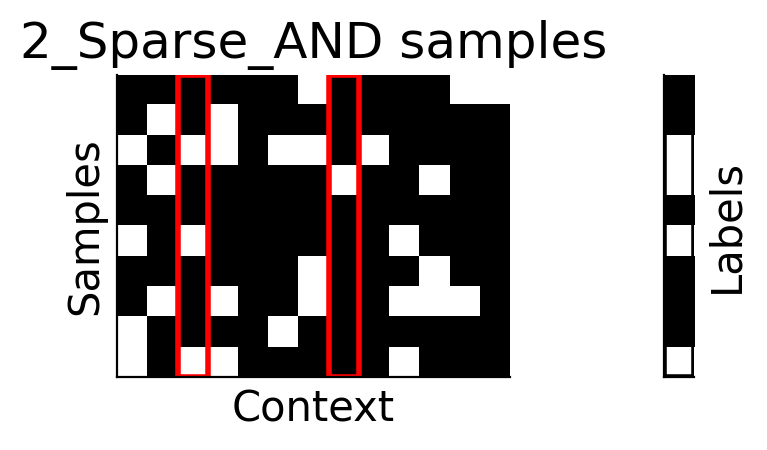

In [16]:
context_length = 13  # T: context length
s_sparse = 2  # s: sparsity (number of function-relevant indices)
n_sequences = 10  # m: number of samples (sequences)
data_gen = s_Sparse_AND(context_length, s_sparse)
X_, y_ = data_gen.generate(n_sequences, verbose=False)
correct_ids = data_gen.f_i
print(f"Target (function-relevant indices) indices: {correct_ids}")

plot_samples(X_, y_, correct_ids, f"{s_sparse}_Sparse_AND samples")

## Exercise 3. MLP vs. Self-Attention

Let's see which of the two architectures generalizes better in this problem. We will test both on sparse functions (*s* = 3) and denser functions (*s* = 15) for the context length of *T* = 30. We use a helper-function `make_train` that takes the model and hyper-parameters and returns the trained model and some results.

This exercise has 4 parts:

1. Create training and validation datasets
2. Train an MLP and self-attention model on task
3. Plot to compare the results for the two models and two datasets
4. Change the sample complexity of the MLP dataset, to get to 100% accuracy.
5. Plot the attention score (attention weights) for the transformer!

**ABBREVIATIONS:**
- suffix `_s` = sparse
- suffix `_d` = dense
- prefix `t_` = training
- prefix `v_` = validation
- `model_np` = number of parameters
- `sat` = Self-Attention Transformer

In [17]:
# Problem hyperparameters
context_length = 17  # T: context length
sparse_dense = [2, 4]  # s: sparsity (number of function-relevant indices)
B_valid = 500  # batch size for validation


### Exercise 3.1: MLP
Training an MLP on the "s-Sparse AND" task. How does the model do?

In [18]:
# # Hyperparameters for sparse MLP
B_t_mlp = 200  # batch size for training (number of training samples)
n_epochs = 500  # number of epochs
s_sparse = sparse_dense[0]  # sparse
hidden_layers = [512]  # the number of hidden units in each layer [H1, H2, ...]
kind = "MLP"

mlp_model = BinaryMLP(context_length, hidden_layers, 1)  # MLP model
data_gen = s_Sparse_AND_Query(context_length, s_sparse)
results_mlp_s = make_train(mlp_model, data_gen, B_t_mlp, B_valid, n_epochs, DEVICE, kind, verbose=True, etta=1e-3)

Number of model's learnable parameters: 9729
Training loss: 0.013, accuracy: 1.000
Validation loss: 0.029, accuracy: 1.000


In [19]:
# # Hyperparameters for dense MLP
B_t_mlp = 200  # batch size for training (number of training samples)
n_epochs = 500  # number of epochs
s_sparse = sparse_dense[1]  # dense
hidden_layers = [512]  # the number of hidden units in each layer [H1, H2, ...]
kind = "MLP"

mlp_model = BinaryMLP(context_length, hidden_layers, 1)  # MLP model
data_gen = s_Sparse_AND_Query(context_length, s_sparse)
results_mlp_d = make_train(mlp_model, data_gen, B_t_mlp, B_valid, n_epochs, DEVICE, kind, verbose=True, etta=1e-3)

Number of model's learnable parameters: 9729
Training loss: 0.027, accuracy: 1.000
Validation loss: 0.064, accuracy: 0.982


### Exercise 3.2. Self-Attention

Build a Transformer model and train it on the given dataset. How does the training results compare to MLP?

In [20]:
# # Hyperparameters for sparse SAT
B_t_sat = 200  # batch size for training (number of training samples)
n_epochs = 2000  # number of epochs
s_sparse = sparse_dense[0]  # sparse
embed_dim = 2  # embedding dimension
kind = "SAT"

sat_model_s = SelfAttention(context_length, embed_dim)  # selt-attention transformer
data_gen = s_Sparse_AND_Query(context_length, s_sparse)
results_sat_s = make_train(sat_model_s, data_gen, B_t_sat, B_valid, n_epochs, DEVICE, kind, verbose=True, etta=1e-2)

Number of model's learnable parameters: 65
Training loss: 0.000, accuracy: 1.000
Validation loss: 0.031, accuracy: 0.994


In [21]:
# # Hyperparameters for dense SAT
B_t_sat = 200  # batch size for training (number of training samples)
n_epochs = 2000  # number of epochs
s_sparse = sparse_dense[1]  # dense
embed_dim = 2  # embedding dimension
kind = "SAT"

sat_model_d = SelfAttention(context_length, embed_dim)  # selt-attention transformer
data_gen = s_Sparse_AND_Query(context_length, s_sparse)
results_sat_d = make_train(sat_model_d, data_gen, B_t_sat, B_valid, n_epochs, DEVICE, kind, verbose=True, etta=1e-2)

Number of model's learnable parameters: 65
Training loss: 0.000, accuracy: 1.000
Validation loss: 0.034, accuracy: 0.984


### Exercise 3.3. Coding Exercise Comparing results

Here, we ask you to plot the results of the trainings above and the hyper-parameters you think are important. The goal is to show in one plot how Self-Attention Transformers and Multi-Layer Perceptons compare for both sparse and dense boolean tasks. You can use any or all of the following information in your plot:
- number of parameters
- training samples
- validation accuracy
- validation loss

We have provided the results in an ordered dictionary `ordered_results` for your convenience.

Discuss: what components of self-attention may be responsible for this improved performance for sparse functions? What could you add to an MLP that might make it more competitive?

**Hint:** Use your creativity and information-communication skills :)

In [22]:
# Validation loss, accuracy, number of parameters and number of training samples
ordered_results = results_dict(results_sat_d, results_sat_s, results_mlp_d, results_mlp_s)
ordered_results

OrderedDict([('Validation Loss SAT dense', 0.034),
             ('Validation Accuracy SAT dense', 0.984),
             ('Number of Parameters SAT dense', 65),
             ('Validation Loss SAT sparse', 0.031),
             ('Validation Accuracy SAT sparse', 0.994),
             ('Number of Parameters SAT sparse', 65),
             ('Validation Loss MLP dense', 0.064),
             ('Validation Accuracy MLP dense', 0.982),
             ('Number of Parameters MLP dense', 9729),
             ('Validation Loss MLP sparse', 0.029),
             ('Validation Accuracy MLP sparse', 1.0),
             ('Number of Parameters MLP sparse', 9729)])

## Exercise 4. Context-dependent Attention Weights

The *S*-Sparse AND task is not the best task to demonstrate the power of self-attention transformers in learning representations, because even a linear network can learn a single projection of the inputs. Here we design a new task that would be a bit more challenging but also expose more core structure of attention.

For a given a binary sequence, we include a special "Rule" token that specifies which tokens should be included for the AND function. For example: if $x_{\rm rule} = 0$, then the label of sequence should be $x_3~\text{AND}~ x_7$, and if $x_{\rm rule} = 1$, then the label should be $x_2~\text{AND}~ x_5$. Therefore the self-attention should learn to "attend" to $(x_3,x_7)$ OR $(x_2,x_5)$, depending on $x_{\rm rule}$.

Here we will train our model on such task, and then plot how each token affects the output label. Since this is affected by both the attentional weights and the next layer readout, we plot the product $W_\text{readout}\cdot W_\text{attention}$.

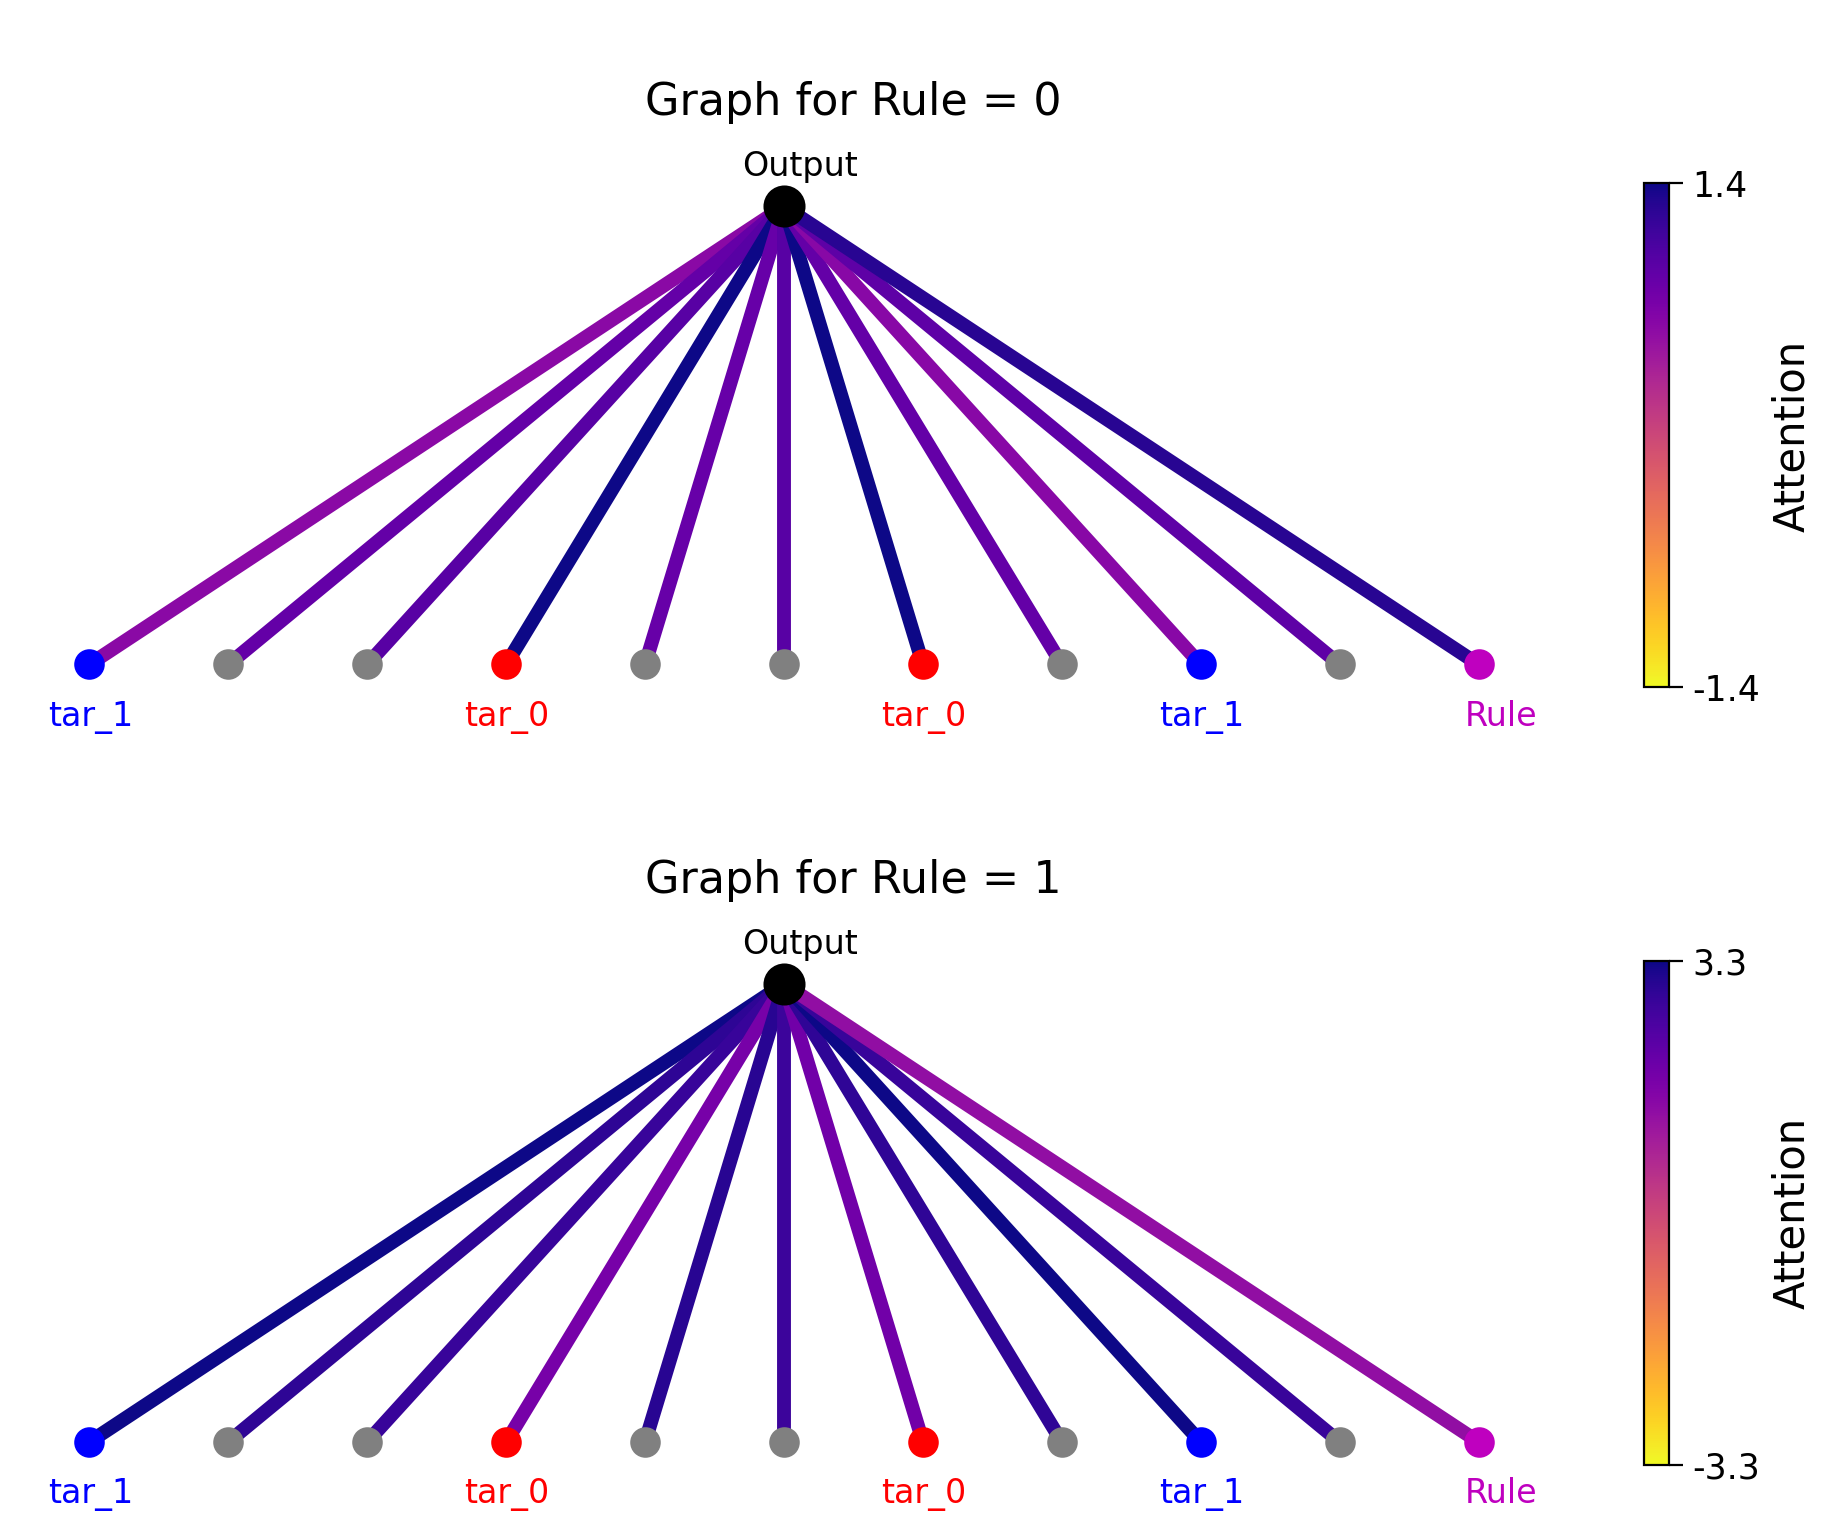

In [23]:
# # Hyperparameters for sparse SAT
context_length = 11  # T: context length
B_t_sat = 300  # batch size for training (number of training samples)
n_epochs = 1000  # number of epochs
s_sparse = 2  # sparse
embed_dim = 2  # embedding dimension
n_sequences = 200  # number of samples for ploting
kind = "SAT"

sat_model_s = SelfAttention(context_length, embed_dim)  # selt-attention transformer
data_gen = s_Sparse_AND_Query(context_length, s_sparse)
_ = make_train(sat_model_s, data_gen, B_t_sat, B_valid, n_epochs, DEVICE, kind, verbose=False, etta=1e-2)

plot_attention_graph(sat_model_s, data_gen, n_sequences)

Under the two different rules, the attention mechanism weighs the input tokens differently for the final output. Plotting the results this way emphasizes how attention can be interpreted as a changing computation graph.

# Conclusion

This tutorial introduced multiplicative attention as a canonical operation in brains and machines, and showed how it has an inductive bias that can help on context-dependent tasks.

The self-attention mechanism of Transformers actually includes all of the canonical NeuroAI operations from this tutorial: sparsifying, normalization, and multiplicative attention. These operations make it easier to generalize in natural tasks.